In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.figsize"] = (10, 6)

DATA_PROCESSED = Path("../data_processed")


In [2]:
# Long-format returns for all tickers
returns_long = pd.read_parquet(DATA_PROCESSED / "returns_long_universe.parquet")

# Active universe (top-K vol per date)
active_universe = pd.read_parquet(
    DATA_PROCESSED / "active_universe_top20_vol_plus_SPY.parquet"
)

# Precomputed dynamic portfolio returns
port_returns = pd.read_parquet(DATA_PROCESSED / "portfolio_returns_dynamic.parquet")

returns_long.head(), active_universe.head(), port_returns.head()


(        date ticker       ret
 0 2010-01-05   AAPL  0.001728
 1 2010-01-05   AMZN  0.005883
 2 2010-01-05    BAC  0.031987
 3 2010-01-05    CVX  0.007058
 4 2010-01-05    GLD -0.000911,
         date ticker  active
 0 2010-04-01   NVDA    True
 1 2010-04-01    BAC    True
 2 2010-04-01    UNH    True
 3 2010-04-01    SLV    True
 4 2010-04-01   AMZN    True,
             date         portfolio       ret
 15784 2010-01-05  Markowitz_static  0.003374
 15785 2010-01-06  Markowitz_static -0.002281
 15786 2010-01-07  Markowitz_static  0.004022
 15787 2010-01-08  Markowitz_static  0.000735
 15788 2010-01-11  Markowitz_static -0.002843)

In [3]:
class AssetBanditEnv:
    """
    Bandit environment over individual assets with a dynamic active universe.

    Data assumptions:
      - returns_long: ['date', 'ticker', 'ret']
      - active_universe: ['date', 'ticker']
    """

    def __init__(self, returns_long: pd.DataFrame, active_universe: pd.DataFrame):
        df = returns_long.merge(
            active_universe[["date", "ticker"]],
            on=["date", "ticker"],
            how="inner",
        )
        df = df.sort_values("date")

        self.data = df
        self.dates = df["date"].unique()
        self.current_idx = 0

    def reset(self):
        self.current_idx = 0

    def current_date(self):
        return self.dates[self.current_idx]

    def available_arms(self):
        d = self.current_date()
        return (
            self.data.loc[self.data["date"] == d, "ticker"]
            .unique()
            .tolist()
        )

    def step(self, chosen_ticker: str):
        """
        chosen_ticker must be one of available_arms()
        Returns: date, ret, done
        """
        d = self.current_date()
        mask = (self.data["date"] == d) & (self.data["ticker"] == chosen_ticker)
        r = float(self.data.loc[mask, "ret"].iloc[0])

        self.current_idx += 1
        done = self.current_idx >= len(self.dates)

        return d, r, done


class PortfolioBanditEnv:
    """
    Bandit environment over portfolio templates.

    Data assumptions:
      - port_returns: ['date', 'portfolio', 'ret']
    """

    def __init__(self, port_returns: pd.DataFrame):
        # Sort and store
        df = port_returns.sort_values(["date", "portfolio"])
        self.data = df

        # Unique trading dates
        self.dates = df["date"].unique()

        # Start index
        self.current_idx = 0

    def reset(self):
        self.current_idx = 0

    def current_date(self):
        return self.dates[self.current_idx]

    def available_arms(self):
        """
        Portfolios actually available on the current date.

        This is crucial: some templates (e.g., Markowitz, MOM_top5)
        may only exist after a warmup window. We must NOT offer
        portfolios that do not have a row on the current date.
        """
        d = self.current_date()
        return (
            self.data.loc[self.data["date"] == d, "portfolio"]
            .unique()
            .tolist()
        )

    def step(self, portfolio_name: str):
        """
        portfolio_name must be in available_arms() for the current date.
        Returns: date, ret, done
        """
        d = self.current_date()
        mask = (self.data["date"] == d) & (self.data["portfolio"] == portfolio_name)

        # Defensive check to avoid silent IndexError
        if not mask.any():
            raise ValueError(
                f"No row found for date={d} and portfolio={portfolio_name}. "
                f"Available arms on that date are: "
                f"{self.data.loc[self.data['date'] == d, 'portfolio'].unique().tolist()}"
            )

        r = float(self.data.loc[mask, "ret"].iloc[0])

        self.current_idx += 1
        done = self.current_idx >= len(self.dates)

        return d, r, done



In [4]:
asset_env = AssetBanditEnv(returns_long, active_universe)
port_env  = PortfolioBanditEnv(port_returns)

asset_env.current_date(), asset_env.available_arms()[:5], port_env.available_arms()


(Timestamp('2010-04-01 00:00:00'),
 ['AAPL', 'XOM', 'WFC', 'UNH', 'SPY'],
 ['Markowitz_static'])

In [5]:
# -------------------------------------------------------------------
# Performance metrics
# -------------------------------------------------------------------
def perf_stats(df: pd.DataFrame, ret_col: str = "ret", freq: int = 252):
    """
    Compute annualised mean, vol, Sharpe, Sortino, and max drawdown
    from a DataFrame with a 'ret' column.
    Assumes risk-free rate = 0.
    """
    r = df[ret_col].dropna()

    # Annualised mean and volatility
    ann_mu = r.mean() * freq
    ann_sigma = r.std() * np.sqrt(freq)
    sharpe = ann_mu / ann_sigma if ann_sigma > 0 else np.nan

    # Sortino: only downside volatility (r < 0)
    downside = r[r < 0]
    if len(downside) > 1:
        downside_sigma = downside.std() * np.sqrt(freq)
        sortino = ann_mu / downside_sigma if downside_sigma > 0 else np.nan
    else:
        sortino = np.nan

    # Equity curve and max drawdown
    equity = (1.0 + r).cumprod()
    peak = equity.cummax()
    dd = equity / peak - 1.0
    max_dd = dd.min()

    return {
        "ann_mu": ann_mu,
        "ann_sigma": ann_sigma,
        "sharpe": sharpe,
        "sortino": sortino,
        "max_dd": max_dd,
    }


In [6]:
# -------------------------------------------------------------------
# Simulators
# -------------------------------------------------------------------
def run_asset_bandit(env, policy, label: str, transaction_cost: float = 0.0):
    """
    Run an asset-level bandit simulation.
    Returns: DataFrame ['date','chosen','ret','wealth','strategy'].
    """
    env.reset()
    wealth = 1.0
    history = []

    prev_arm = None

    while True:
        date = env.current_date()
        arms = env.available_arms()
        if not arms:
            break

        chosen = policy.select(arms)
        d, r, done = env.step(chosen)

        # Apply transaction cost if we changed arms
        cost = 0.0
        if prev_arm is not None and chosen != prev_arm:
            cost = transaction_cost

        net_r = r - cost
        wealth *= (1.0 + net_r)

        # you can choose r vs net_r here; we keep r for learning signal
        policy.update(chosen, r)

        history.append((d, chosen, net_r, wealth, label))

        prev_arm = chosen
        if done:
            break

    result = pd.DataFrame(history, columns=["date", "chosen", "ret", "wealth", "strategy"])
    return result


def run_portfolio_benchmark(port_returns: pd.DataFrame,
                            portfolio_name: str,
                            label: str = None):
    """
    Deterministic benchmark: always hold the same portfolio template
    over time (e.g. 'EW_active', 'EW_top5vol', 'MOM_top5').

    Returns: ['date','portfolio','ret','wealth','strategy']
    """
    if label is None:
        label = portfolio_name

    df = (
        port_returns
        .loc[port_returns["portfolio"] == portfolio_name]
        .sort_values("date")
        .copy()
    )

    if df.empty:
        raise ValueError(f"No rows found for portfolio '{portfolio_name}' in port_returns.")

    df["wealth"] = (1.0 + df["ret"]).cumprod()
    df["strategy"] = label

    return df[["date", "portfolio", "ret", "wealth", "strategy"]]


def run_portfolio_bandit(env: PortfolioBanditEnv, policy, label: str):
    """
    Run a portfolio-level bandit simulation over portfolio templates.

    Returns: ['date','portfolio','ret','wealth','strategy']
    """
    env.reset()
    wealth = 1.0
    history = []

    while True:
        date = env.current_date()
        arms = env.available_arms()
        if not arms:
            break

        chosen = policy.select(arms)
        d, r, done = env.step(chosen)

        wealth *= (1.0 + r)
        policy.update(chosen, r)

        history.append((d, chosen, r, wealth, label))

        if done:
            break

    result = pd.DataFrame(history, columns=["date", "portfolio", "ret", "wealth", "strategy"])
    return result


In [7]:
# -------------------------------------------------------------------
# Bandit policies
# -------------------------------------------------------------------
class NIGThompsonCVaRPolicy:
    """
    Risk-aware Thompson Sampling policy using a Normal-Inverse-Gamma model
    and Monte Carlo CVaR on the posterior predictive.
    """

    def __init__(
        self,
        mu0=0.0,
        kappa0=1e-4,
        alpha0=2.0,
        beta0=1.0,
        alpha_tail=0.05,
        num_samples=200,
        seed=None,
    ):
        self.mu0 = mu0
        self.kappa0 = kappa0
        self.alpha0 = alpha0
        self.beta0 = beta0

        self.alpha_tail = alpha_tail
        self.num_samples = num_samples

        self.arms = {}  # arm -> dict(n, sum_x, sum_x2)
        self.rng = np.random.default_rng(seed)

    def _ensure_arm(self, arm):
        if arm not in self.arms:
            self.arms[arm] = {"n": 0, "sum_x": 0.0, "sum_x2": 0.0}

    def _posterior_params(self, st):
        n = st["n"]
        if n == 0:
            mu_n = self.mu0
            kappa_n = self.kappa0
            alpha_n = self.alpha0
            beta_n = self.beta0
        else:
            sum_x = st["sum_x"]
            sum_x2 = st["sum_x2"]
            xbar = sum_x / n

            kappa_n = self.kappa0 + n
            mu_n = (self.kappa0 * self.mu0 + n * xbar) / kappa_n
            alpha_n = self.alpha0 + 0.5 * n

            sse = sum_x2 - n * (xbar ** 2)
            beta_n = (
                self.beta0
                + 0.5 * sse
                + (self.kappa0 * n * (xbar - self.mu0) ** 2) / (2.0 * kappa_n)
            )

        return mu_n, kappa_n, alpha_n, beta_n

    def _sample_predictive_cvar(self, mu_n, kappa_n, alpha_n, beta_n):
        gamma_samples = self.rng.gamma(
            shape=alpha_n,
            scale=1.0 / beta_n,
            size=self.num_samples,
        )
        sigma2_samples = 1.0 / gamma_samples

        mu_samples = self.rng.normal(
            loc=mu_n,
            scale=np.sqrt(sigma2_samples / kappa_n),
        )

        ret_samples = self.rng.normal(
            loc=mu_samples,
            scale=np.sqrt(sigma2_samples),
        )

        q_alpha = np.quantile(ret_samples, self.alpha_tail)
        tail = ret_samples[ret_samples <= q_alpha]

        if tail.size == 0:
            cvar = q_alpha
        else:
            cvar = tail.mean()

        return cvar

    def select(self, arms):
        for arm in arms:
            self._ensure_arm(arm)

        cvar_scores = {}
        for arm in arms:
            st = self.arms[arm]
            mu_n, kappa_n, alpha_n, beta_n = self._posterior_params(st)
            cvar_scores[arm] = self._sample_predictive_cvar(mu_n, kappa_n, alpha_n, beta_n)

        return max(cvar_scores, key=cvar_scores.get)

    def update(self, arm, reward: float):
        self._ensure_arm(arm)
        st = self.arms[arm]
        st["n"] += 1
        st["sum_x"] += reward
        st["sum_x2"] += reward ** 2


class NIGThompsonMeanPolicy:
    """
    Thompson Sampling policy for a Normal likelihood with unknown mean and variance,
    using a Normal-Inverse-Gamma prior.
    """

    def __init__(self, mu0=0.0, kappa0=1e-4, alpha0=2.0, beta0=1.0, seed=None):
        self.mu0 = mu0
        self.kappa0 = kappa0
        self.alpha0 = alpha0
        self.beta0 = beta0

        self.arms = {}  # arm -> dict(n, sum_x, sum_x2)
        self.rng = np.random.default_rng(seed)

    def _ensure_arm(self, arm):
        if arm not in self.arms:
            self.arms[arm] = {"n": 0, "sum_x": 0.0, "sum_x2": 0.0}

    def select(self, arms):
        for arm in arms:
            self._ensure_arm(arm)

        samples = {}
        for arm in arms:
            st = self.arms[arm]
            n = st["n"]

            if n == 0:
                mu_n = self.mu0
                kappa_n = self.kappa0
                alpha_n = self.alpha0
                beta_n = self.beta0
            else:
                sum_x = st["sum_x"]
                sum_x2 = st["sum_x2"]
                xbar = sum_x / n

                kappa_n = self.kappa0 + n
                mu_n = (self.kappa0 * self.mu0 + n * xbar) / kappa_n
                alpha_n = self.alpha0 + 0.5 * n

                sse = sum_x2 - n * (xbar ** 2)
                beta_n = (
                    self.beta0
                    + 0.5 * sse
                    + (self.kappa0 * n * (xbar - self.mu0) ** 2) / (2.0 * kappa_n)
                )

            gamma_sample = self.rng.gamma(shape=alpha_n, scale=1.0 / beta_n)
            sigma2 = 1.0 / gamma_sample
            mu_sample = self.rng.normal(loc=mu_n, scale=np.sqrt(sigma2 / kappa_n))
            samples[arm] = mu_sample

        return max(samples, key=samples.get)

    def update(self, arm, reward: float):
        self._ensure_arm(arm)
        st = self.arms[arm]
        st["n"] += 1
        st["sum_x"] += reward
        st["sum_x2"] += reward ** 2


In [8]:
ew_active_results = run_portfolio_benchmark(
    port_returns=port_returns,
    portfolio_name="EW_active",
    label="EW_active_benchmark"
)

ew_active_results.head()




,date,portfolio,ret,wealth,strategy
0,2010-04-01,EW_active,0.003725,1.003725,EW_active_benchmark
4,2010-04-05,EW_active,0.005154,1.008898,EW_active_benchmark
8,2010-04-06,EW_active,0.002564,1.011485,EW_active_benchmark
12,2010-04-07,EW_active,-0.001167,1.010305,EW_active_benchmark
16,2010-04-08,EW_active,0.005380,1.015740,EW_active_benchmark


In [9]:
ew_top5_results = run_portfolio_benchmark(
    port_returns=port_returns,
    portfolio_name="EW_top5vol",
    label="EW_top5vol_benchmark"
)
ew_top5_results.head()

,date,portfolio,ret,wealth,strategy
1,2010-04-01,EW_top5vol,0.000865,1.000865,EW_top5vol_benchmark
5,2010-04-05,EW_top5vol,0.006794,1.007665,EW_top5vol_benchmark
9,2010-04-06,EW_top5vol,0.005087,1.012790,EW_top5vol_benchmark
13,2010-04-07,EW_top5vol,0.000582,1.013379,EW_top5vol_benchmark
17,2010-04-08,EW_top5vol,0.003409,1.016834,EW_top5vol_benchmark


In [10]:
mom_top5_results = run_portfolio_benchmark(
    port_returns=port_returns,
    portfolio_name="MOM_top5",
    label="MOM_top5_benchmark"
)
mom_top5_results.head()

,date,portfolio,ret,wealth,strategy
2,2010-04-01,MOM_top5,0.006863,1.006863,MOM_top5_benchmark
6,2010-04-05,MOM_top5,0.006640,1.013549,MOM_top5_benchmark
10,2010-04-06,MOM_top5,0.009540,1.023218,MOM_top5_benchmark
14,2010-04-07,MOM_top5,0.000355,1.023581,MOM_top5_benchmark
18,2010-04-08,MOM_top5,0.003924,1.027597,MOM_top5_benchmark


In [11]:
lowvol_top5_results = run_portfolio_benchmark(
    port_returns=port_returns,
    portfolio_name="LOWVOL_top5",
    label="LOWVOL_top5_benchmark"
)
lowvol_top5_results.head()

,date,portfolio,ret,wealth,strategy
3,2010-04-01,LOWVOL_top5,0.006579,1.006579,LOWVOL_top5_benchmark
7,2010-04-05,LOWVOL_top5,0.006108,1.012727,LOWVOL_top5_benchmark
11,2010-04-06,LOWVOL_top5,-0.001329,1.011380,LOWVOL_top5_benchmark
15,2010-04-07,LOWVOL_top5,-0.006348,1.004960,LOWVOL_top5_benchmark
19,2010-04-08,LOWVOL_top5,0.003207,1.008183,LOWVOL_top5_benchmark


In [12]:
markowitz_results = run_portfolio_benchmark(
    port_returns=port_returns,
    portfolio_name="Markowitz_static",
    label="Markowitz_static"
)
markowitz_results.head()

,date,portfolio,ret,wealth,strategy
15784,2010-01-05,Markowitz_static,0.003374,1.003374,Markowitz_static
15785,2010-01-06,Markowitz_static,-0.002281,1.001085,Markowitz_static
15786,2010-01-07,Markowitz_static,0.004022,1.005112,Markowitz_static
15787,2010-01-08,Markowitz_static,0.000735,1.005851,Markowitz_static
15788,2010-01-11,Markowitz_static,-0.002843,1.002992,Markowitz_static


In [13]:
class FunctionPolicyWrapper:
    def __init__(self, select_func, update_func):
        self._select = select_func
        self._update = update_func

    def select(self, arms):
        return self._select(arms)

    def update(self, arm, reward):
        return self._update(arm, reward)


In [14]:
# Asset-level TS-mean on individual tickers
asset_env = AssetBanditEnv(returns_long, active_universe)
ts_mean_asset_policy = NIGThompsonMeanPolicy(seed=42)

asset_ts_mean_results = run_asset_bandit(
    env=asset_env,
    policy=ts_mean_asset_policy,
    label="TS_mean_asset",
)

asset_ts_mean_results.head()


,date,chosen,ret,wealth,strategy
0,2010-04-01,UNH,0.010666,1.010666,TS_mean_asset
1,2010-04-05,HD,0.008610,1.019368,TS_mean_asset
2,2010-04-06,QQQ,0.002876,1.022300,TS_mean_asset
3,2010-04-07,PFE,0.006465,1.028908,TS_mean_asset
4,2010-04-08,XOM,0.007693,1.036823,TS_mean_asset


In [15]:
stats = perf_stats(asset_ts_mean_results, ret_col="ret")
print("TS_mean_asset →",
      "ann μ:", stats["ann_mu"],
      "ann σ:", stats["ann_sigma"],
      "Sharpe:", stats["sharpe"],
      "max DD:", stats["max_dd"],
      "Sortino:", stats["sortino"]
      )


TS_mean_asset → ann μ: 0.10592104595925378 ann σ: 0.26793401622549873 Sharpe: 0.39532511568112527 max DD: -0.4188483656210482 Sortino: 0.5116708032010807


In [16]:
# --- Risk-aware TS (CVaR-based) on individual assets ---

asset_env = AssetBanditEnv(returns_long, active_universe)

ts_cvar_asset_policy = NIGThompsonCVaRPolicy(
    alpha_tail=0.05,    # 5% CVaR
    num_samples=200,
    seed=1234,
)

asset_ts_cvar_results = run_asset_bandit(
    env=asset_env,
    policy=ts_cvar_asset_policy,
    label="TS_cvar_asset",
)

asset_ts_cvar_results.head()

# Compute performance stats
stats_cvar = perf_stats(asset_ts_cvar_results, ret_col="ret")
print("TS_cvar_asset →",
      "ann μ:", stats_cvar["ann_mu"],
      "ann σ:", stats_cvar["ann_sigma"],
      "Sharpe:", stats_cvar["sharpe"],
      "max DD:", stats_cvar["max_dd"],
      "Sortino:", stats_cvar["sortino"]
      )


TS_cvar_asset → ann μ: 0.15330195536552638 ann σ: 0.27603509513898206 Sharpe: 0.5553712483129717 max DD: -0.4729679290425556 Sortino: 0.7422864115847905


In [17]:
# Portfolio-level TS-mean over portfolio templates (EW_active, EW_top5vol, etc.)
port_env = PortfolioBanditEnv(port_returns)
ts_mean_port_policy = NIGThompsonMeanPolicy(seed=123)

port_ts_mean_results = run_portfolio_bandit(
    env=port_env,
    policy=ts_mean_port_policy,
    label="TS_mean_port",
)
port_ts_mean_results.head()



,date,portfolio,ret,wealth,strategy
0,2010-01-05,Markowitz_static,0.003374,1.003374,TS_mean_port
1,2010-01-06,Markowitz_static,-0.002281,1.001085,TS_mean_port
2,2010-01-07,Markowitz_static,0.004022,1.005112,TS_mean_port
3,2010-01-08,Markowitz_static,0.000735,1.005851,TS_mean_port
4,2010-01-11,Markowitz_static,-0.002843,1.002992,TS_mean_port


In [18]:
stats_p = perf_stats(port_ts_mean_results, ret_col="ret")
print("TS_mean_port →",
      "ann μ:", stats_p["ann_mu"],
      "ann σ:", stats_p["ann_sigma"],
      "Sharpe:", stats_p["sharpe"],
      "max DD:", stats_p["max_dd"],
      "Sortino:", stats_p["sortino"]
      )


TS_mean_port → ann μ: 0.17305321422929665 ann σ: 0.18768304095297833 Sharpe: 0.922050353354265 max DD: -0.25924989491075057 Sortino: 1.1393274629223562


In [19]:
# --- Portfolio-level risk-aware TS (CVaR-based) over portfolio templates ---

port_env = PortfolioBanditEnv(port_returns)
ts_cvar_port_policy = NIGThompsonCVaRPolicy(
    alpha_tail=0.05,
    num_samples=200,
    seed=2025,
)

port_ts_cvar_results = run_portfolio_bandit(
    env=port_env,
    policy=ts_cvar_port_policy,
    label="TS_cvar_port",
)

stats_p_cvar = perf_stats(port_ts_cvar_results, ret_col="ret")
print("TS_cvar_port →",
      "ann μ:", stats_p_cvar["ann_mu"],
      "ann σ:", stats_p_cvar["ann_sigma"],
      "Sharpe:", stats_p_cvar["sharpe"],
      "max DD:", stats_p_cvar["max_dd"],
      "Sortino:", stats_p_cvar["sortino"])


TS_cvar_port → ann μ: 0.08739314888982948 ann σ: 0.07913800579323657 Sharpe: 1.104313256492223 max DD: -0.20292931128938219 Sortino: 1.3813922978642807


In [20]:
# --- Risk-aware TS (CVaR-based) at PORTFOLIO level ---

port_env_cvar = PortfolioBanditEnv(port_returns)

ts_cvar_port_policy = NIGThompsonCVaRPolicy(
    alpha_tail=0.05,    # 5% CVaR tail
    num_samples=200,
    seed=2025,
)

port_ts_cvar_results = run_portfolio_bandit(
    env=port_env_cvar,
    policy=ts_cvar_port_policy,
    label="TS_cvar_port",
)

# Optional: inspect performance
stats_cvar_port = perf_stats(port_ts_cvar_results, ret_col="ret")
print("TS_cvar_port →",
      "ann μ:", stats_cvar_port["ann_mu"],
      "ann σ:", stats_cvar_port["ann_sigma"],
      "Sharpe:", stats_cvar_port["sharpe"],
      "Sortino:", stats_cvar_port["sortino"],
      "max DD:", stats_cvar_port["max_dd"])


TS_cvar_port → ann μ: 0.08739314888982948 ann σ: 0.07913800579323657 Sharpe: 1.104313256492223 Sortino: 1.3813922978642807 max DD: -0.20292931128938219


In [21]:
# SPY buy & hold benchmark
spy_ret = (
    returns_long.query("ticker == 'SPY'")
    .sort_values("date")[["date", "ret"]]
    .copy()
)

spy_ret["wealth"] = (1.0 + spy_ret["ret"]).cumprod()
spy_ret["strategy"] = "SPY_buy_and_hold"

spy_equity = (1.0 + spy_ret["ret"]).cumprod()
ts_equity = asset_ts_mean_results.set_index("date")["wealth"]

asset_ts_mean_results = asset_ts_mean_results.sort_values("date")

# For consistency with asset bandit results:
spy_results = spy_ret[["date", "ret", "wealth", "strategy"]]
spy_results.head()



,date,ret,wealth,strategy
21,2010-01-05,0.002644,1.002644,SPY_buy_and_hold
47,2010-01-06,0.000703,1.003349,SPY_buy_and_hold
73,2010-01-07,0.004213,1.007576,SPY_buy_and_hold
99,2010-01-08,0.003322,1.010923,SPY_buy_and_hold
125,2010-01-11,0.001396,1.012334,SPY_buy_and_hold


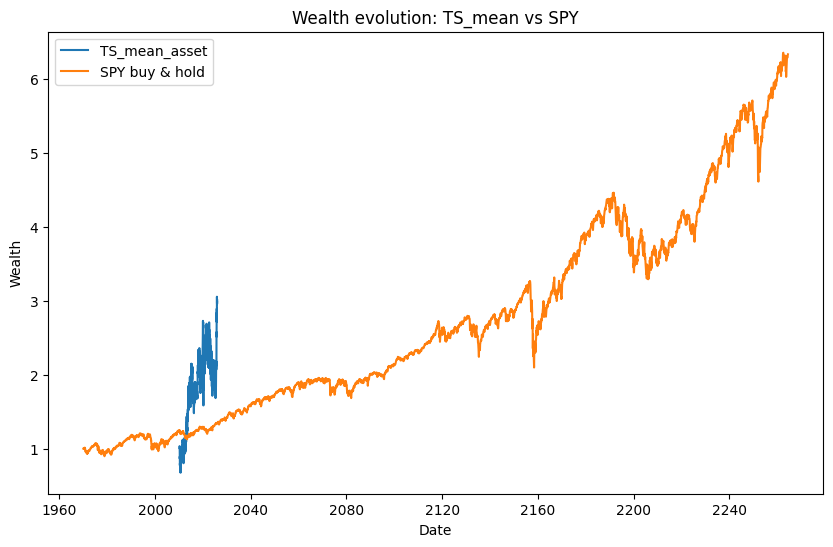

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(ts_equity.index, ts_equity, label="TS_mean_asset")
plt.plot(spy_equity.index, spy_equity, label="SPY buy & hold")
plt.title("Wealth evolution: TS_mean vs SPY")
plt.xlabel("Date")
plt.ylabel("Wealth")
plt.legend()
plt.show()


In [23]:
asset_ts_mean_results["chosen"].value_counts().head(20)


chosen
GOOGL    192
META     190
UNH      187
MSFT     184
CVX      183
AAPL     182
XOM      181
HD       179
NVDA     179
QQQ      173
SPY      172
MRK      172
JPM      170
WFC      167
PFE      163
BAC      162
SLV      159
PG       156
GS       148
AMZN     144
Name: count, dtype: int64

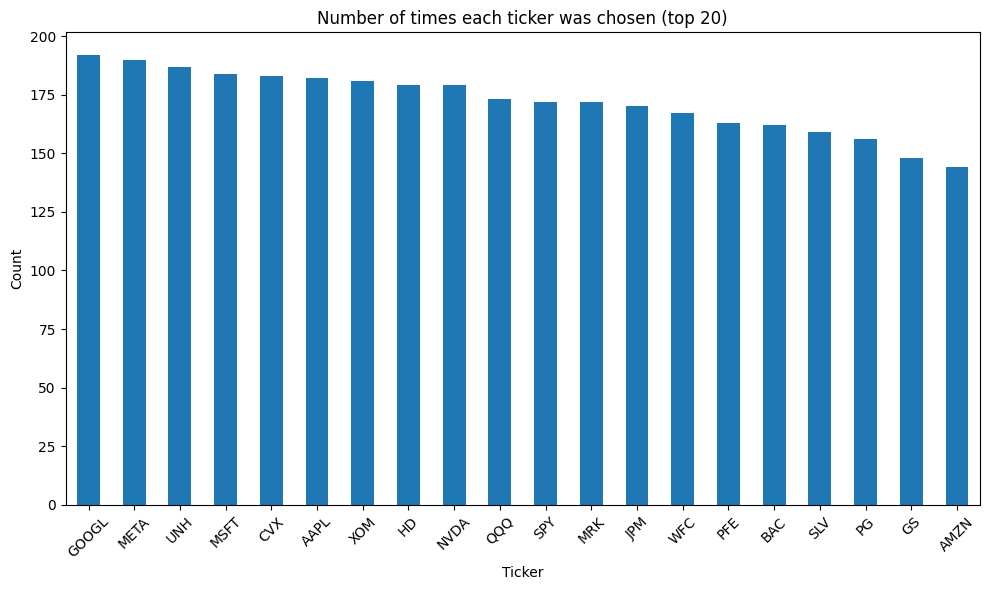

In [24]:
counts = asset_ts_mean_results["chosen"].value_counts()

plt.figure(figsize=(10, 6))
counts.head(20).plot(kind="bar")
plt.title("Number of times each ticker was chosen (top 20)")
plt.ylabel("Count")
plt.xlabel("Ticker")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


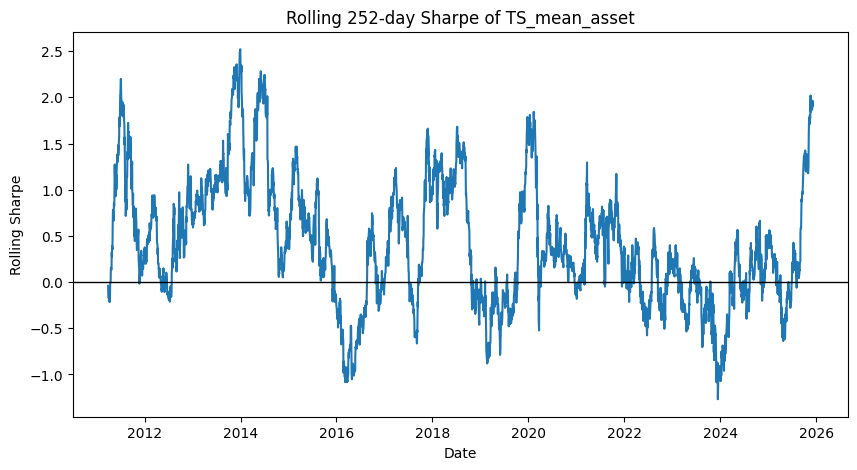

In [25]:
r = asset_ts_mean_results.set_index("date")["ret"]

window = 252
roll_mu = r.rolling(window).mean() * 252
roll_sigma = r.rolling(window).std() * (252 ** 0.5)
roll_sharpe = roll_mu / roll_sigma

plt.figure(figsize=(10, 5))
plt.plot(roll_sharpe.index, roll_sharpe)
plt.title(f"Rolling {window}-day Sharpe of TS_mean_asset")
plt.xlabel("Date")
plt.ylabel("Rolling Sharpe")
plt.axhline(0, color="black", linewidth=1)
plt.show()


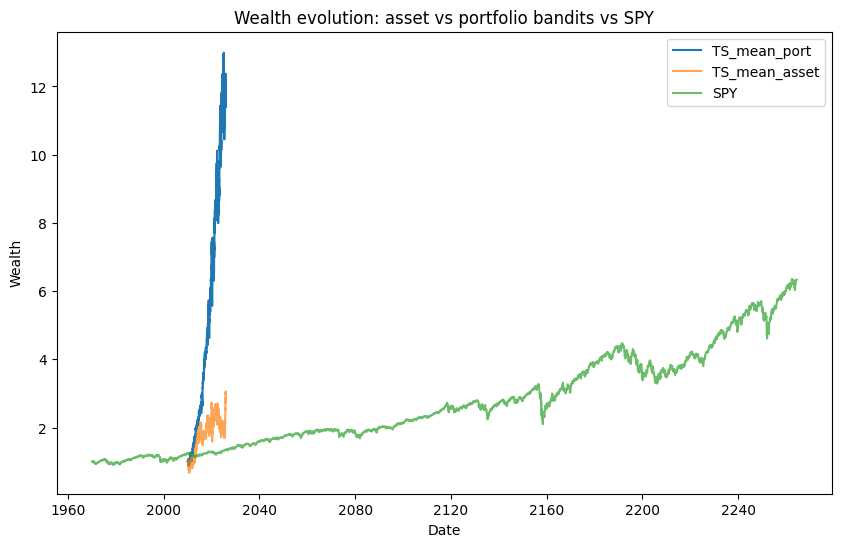

In [26]:
port_ts_mean_results = port_ts_mean_results.sort_values("date")

plt.figure(figsize=(10, 6))
plt.plot(port_ts_mean_results["date"], port_ts_mean_results["wealth"], label="TS_mean_port")
plt.plot(ts_equity.index, ts_equity, label="TS_mean_asset", alpha=0.7)
plt.plot(spy_equity.index, spy_equity, label="SPY", alpha=0.7)
plt.title("Wealth evolution: asset vs portfolio bandits vs SPY")
plt.xlabel("Date")
plt.ylabel("Wealth")
plt.legend()
plt.show()


In [27]:
strategies = {
    "SPY_buy_and_hold": spy_results,
    "TS_mean_asset": asset_ts_mean_results,
    "TS_cvar_asset": asset_ts_cvar_results,
    "TS_mean_port": port_ts_mean_results,
    "TS_cvar_port": port_ts_cvar_results,
    "EW_active": ew_active_results,
    "EW_top5vol": ew_top5_results,
    "MOM_top5": mom_top5_results,
    "LOWVOL_top5": lowvol_top5_results,
    "Markowitz_static": markowitz_results,
}


In [28]:
rows = []
for name, df in strategies.items():
    stats = perf_stats(df, ret_col="ret")
    rows.append({
        "strategy": name,
        "ann_mu": stats["ann_mu"],
        "ann_sigma": stats["ann_sigma"],
        "sharpe": stats["sharpe"],
        "sortino": stats["sortino"],
        "max_dd": stats["max_dd"],
    })

perf_table = pd.DataFrame(rows).set_index("strategy")
perf_table


,ann_mu,ann_sigma,sharpe,sortino,max_dd
strategy,,,,,
SPY_buy_and_hold,0.131127,0.172706,0.759249,0.912573,-0.357459
TS_mean_asset,0.105921,0.267934,0.395325,0.511671,-0.418848
TS_cvar_asset,0.153302,0.276035,0.555371,0.742286,-0.472968
TS_mean_port,0.173053,0.187683,0.922050,1.139327,-0.259250
TS_cvar_port,0.087393,0.079138,1.104313,1.381392,-0.202929
EW_active,0.149012,0.175566,0.848753,1.022129,-0.353408
EW_top5vol,0.190759,0.270494,0.705225,0.916400,-0.503470
MOM_top5,0.207569,0.204066,1.017165,1.305584,-0.329762
LOWVOL_top5,0.087587,0.136741,0.640528,0.792427,-0.214647


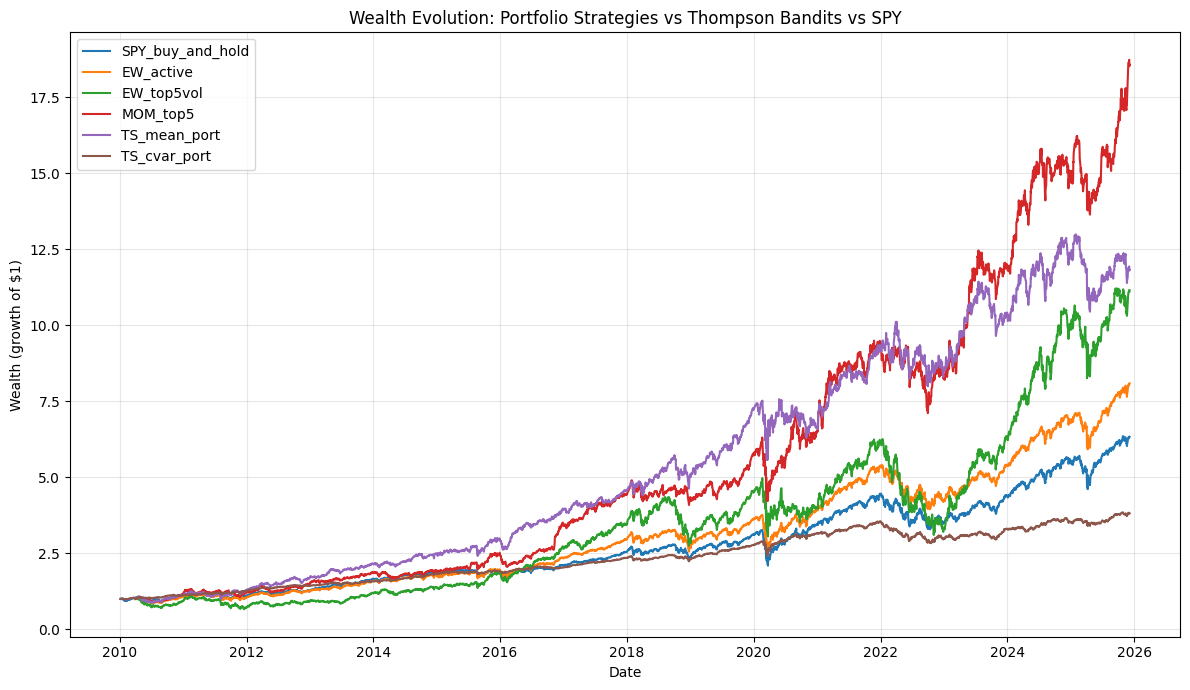

In [29]:
# --- Combined wealth comparison plot: all portfolio strategies + TS_mean_port + TS_cvar_port + SPY ---

plt.figure(figsize=(12, 7))

strategy_series = [
    ("SPY_buy_and_hold", spy_results),
    ("EW_active",        ew_active_results),
    ("EW_top5vol",       ew_top5_results),
    ("MOM_top5",         mom_top5_results),
    ("TS_mean_port",     port_ts_mean_results),
    ("TS_cvar_port",     port_ts_cvar_results),
]

for label, df in strategy_series:
    df_ = df.sort_values("date").copy()
    plt.plot(df_["date"], df_["wealth"], label=label)

plt.title("Wealth Evolution: Portfolio Strategies vs Thompson Bandits vs SPY")
plt.xlabel("Date")
plt.ylabel("Wealth (growth of $1)")
# If curves are very spread out, uncomment this:
# plt.yscale("log")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [30]:
def plot_equity_curves(equity_dict, title):
    plt.figure(figsize=(10, 6))
    for label, series in equity_dict.items():
        plt.plot(series.index, series.values, label=label)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Wealth")
    plt.legend()
    plt.show()


Posterior predictive for SPY:
 mean: -8.895103908115663e-05
 5% quantile: -0.1782167509525111
 95% quantile: 0.17962248543042666

Realised SPY returns (last 252 days):
 empirical mean: 0.0005519233602551523
 empirical std: 0.012307821652809628
 fraction below predictive 5% quantile: 0.0


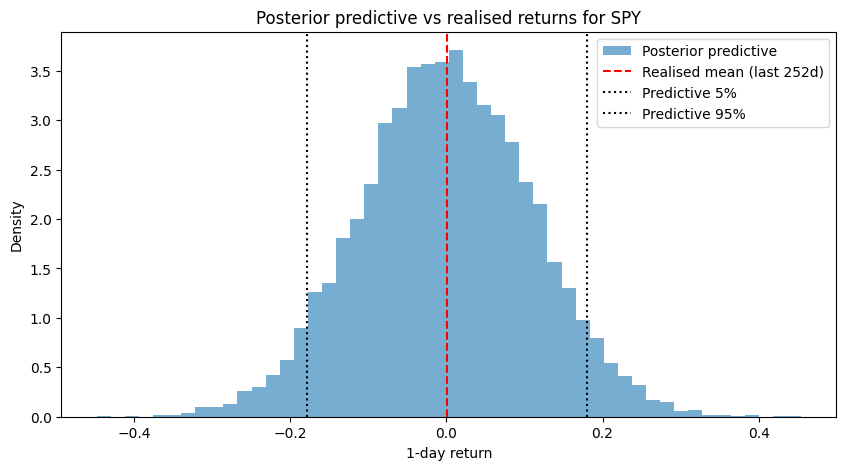

In [31]:
# --- Posterior predictive check for one arm (e.g. SPY) ---

def nig_posterior_params_from_stats(mu0, kappa0, alpha0, beta0, st):
    """
    Given prior hyperparameters and sufficient stats st = {n, sum_x, sum_x2},
    compute (mu_n, kappa_n, alpha_n, beta_n) for the NIG posterior.
    """
    n = st["n"]

    if n == 0:
        # Pure prior
        mu_n = mu0
        kappa_n = kappa0
        alpha_n = alpha0
        beta_n = beta0
    else:
        sum_x = st["sum_x"]
        sum_x2 = st["sum_x2"]
        xbar = sum_x / n

        kappa_n = kappa0 + n
        mu_n = (kappa0 * mu0 + n * xbar) / kappa_n
        alpha_n = alpha0 + 0.5 * n

        # Sum of squared deviations around the sample mean
        sse = sum_x2 - n * (xbar ** 2)

        beta_n = (
            beta0
            + 0.5 * sse
            + (kappa0 * n * (xbar - mu0) ** 2) / (2.0 * kappa_n)
        )

    return mu_n, kappa_n, alpha_n, beta_n


def posterior_predictive_samples_nig(mu_n, kappa_n, alpha_n, beta_n,
                                     num_samples=5000, rng=None):
    """
    Draw samples from the posterior predictive of r:

        sigma^2 ~ Inv-Gamma(alpha_n, beta_n)
        mu      ~ Normal(mu_n, sigma^2 / kappa_n)
        r       ~ Normal(mu, sigma^2)

    Returns np.array of samples.
    """
    if rng is None:
        rng = np.random.default_rng()

    # sigma^2 ~ Inv-Gamma(alpha_n, beta_n)
    gamma_samples = rng.gamma(shape=alpha_n, scale=1.0 / beta_n, size=num_samples)
    sigma2_samples = 1.0 / gamma_samples

    # mu ~ Normal(mu_n, sigma^2 / kappa_n)
    mu_samples = rng.normal(loc=mu_n, scale=np.sqrt(sigma2_samples / kappa_n))

    # r ~ Normal(mu, sigma^2)
    r_samples = rng.normal(loc=mu_samples, scale=np.sqrt(sigma2_samples))

    return r_samples


# Choose an arm to check; examples: "SPY" or the most-chosen ticker
arm_to_check = "SPY"

# Make sure that arm exists in the policy state
if arm_to_check not in ts_mean_asset_policy.arms:
    raise ValueError(f"Arm {arm_to_check} not found in ts_mean_asset_policy.arms")

st = ts_mean_asset_policy.arms[arm_to_check]

mu_n, kappa_n, alpha_n, beta_n = nig_posterior_params_from_stats(
    mu0=ts_mean_asset_policy.mu0,
    kappa0=ts_mean_asset_policy.kappa0,
    alpha0=ts_mean_asset_policy.alpha0,
    beta0=ts_mean_asset_policy.beta0,
    st=st,
)

rng = np.random.default_rng(123)
ppc_samples = posterior_predictive_samples_nig(
    mu_n, kappa_n, alpha_n, beta_n,
    num_samples=10000,
    rng=rng,
)

# Posterior predictive summary
ppc_mean = np.mean(ppc_samples)
ppc_q05 = np.quantile(ppc_samples, 0.05)
ppc_q95 = np.quantile(ppc_samples, 0.95)

print(f"Posterior predictive for {arm_to_check}:")
print(" mean:", ppc_mean)
print(" 5% quantile:", ppc_q05)
print(" 95% quantile:", ppc_q95)


# Compare with realised 1-day returns (e.g. last 252 days of that arm)
realized = (
    returns_long.query("ticker == @arm_to_check")
    .sort_values("date")
    .tail(252)["ret"]
)

# How many realised returns fall below predictive 5% quantile?
frac_below_q05 = (realized < ppc_q05).mean()

print(f"\nRealised {arm_to_check} returns (last 252 days):")
print(" empirical mean:", realized.mean())
print(" empirical std:", realized.std())
print(" fraction below predictive 5% quantile:", frac_below_q05)

# Optional: visual comparison
plt.figure(figsize=(10, 5))
plt.hist(ppc_samples, bins=50, alpha=0.6, density=True, label="Posterior predictive")
plt.axvline(realized.mean(), color="red", linestyle="--", label="Realised mean (last 252d)")
plt.axvline(ppc_q05, color="black", linestyle=":", label="Predictive 5%")
plt.axvline(ppc_q95, color="black", linestyle=":", label="Predictive 95%")

plt.title(f"Posterior predictive vs realised returns for {arm_to_check}")
plt.xlabel("1-day return")
plt.ylabel("Density")
plt.legend()
plt.show()


In [ ]:
# === PPC targets dictionary ===
# Each entry: idx -> (label, policy_obj, arm_name, kind)
# kind is "asset" (use returns_long[ticker]) or "portfolio" (use port_returns[portfolio])

ppc_targets = {
    1: ("TS_mean_asset: SPY", ts_mean_asset_policy, "SPY", "asset"),
    2: ("TS_mean_asset: most-chosen asset", ts_mean_asset_policy,
        asset_ts_mean_results["chosen"].value_counts().idxmax(), "asset"),
    3: ("TS_cvar_asset: SPY", ts_cvar_asset_policy, "SPY", "asset"),
    4: ("TS_cvar_asset: most-chosen asset", ts_cvar_asset_policy,
        asset_ts_cvar_results["chosen"].value_counts().idxmax(), "asset"),
    5: ("TS_mean_port: EW_active", ts_mean_port_policy, "EW_active", "portfolio"),
    6: ("TS_mean_port: MOM_top5", ts_mean_port_policy, "MOM_top5", "portfolio"),
    # 7: ("TS_mean_port: Markowitz", ts_mean_port_policy, "Markowitz", "portfolio"),  # when you add it
}

# Quick check
for k, (label, policy, arm_name, kind) in ppc_targets.items():
    print(f"{k}: {label} | arm={arm_name} | kind={kind}")


In [ ]:
def run_ppc_for_index(
    k: int,
    num_samples: int = 10000,
    lookback: int = 252,
    rng_seed: int = 123,
):
    """
    Run a posterior predictive check for the k-th PPC target in ppc_targets.

    - Uses the NIG posterior from the given policy and arm.
    - Draws posterior predictive samples.
    - Compares with realised returns (last `lookback` days) for that arm.
    """
    if k not in ppc_targets:
        raise ValueError(f"PPC index {k} not in ppc_targets.")

    label, policy, arm_name, kind = ppc_targets[k]
    print(f"\n=== PPC for target {k}: {label} (arm = {arm_name}, kind = {kind}) ===")

    # Check that the arm was actually updated by that policy
    if arm_name not in policy.arms:
        raise ValueError(f"Arm '{arm_name}' not found in policy.arms. "
                         "Did you run the bandit simulation before calling PPC?")

    st = policy.arms[arm_name]

    # Posterior parameters from sufficient stats
    mu_n, kappa_n, alpha_n, beta_n = nig_posterior_params_from_stats(
        mu0=policy.mu0,
        kappa0=policy.kappa0,
        alpha0=policy.alpha0,
        beta0=policy.beta0,
        st=st,
    )

    rng = np.random.default_rng(rng_seed)
    ppc_samples = posterior_predictive_samples_nig(
        mu_n, kappa_n, alpha_n, beta_n,
        num_samples=num_samples,
        rng=rng,
    )

    # Predictive summary
    ppc_mean = np.mean(ppc_samples)
    ppc_q05 = np.quantile(ppc_samples, 0.05)
    ppc_q95 = np.quantile(ppc_samples, 0.95)

    print("Posterior predictive:")
    print(" mean:", ppc_mean)
    print(" 5% quantile:", ppc_q05)
    print(" 95% quantile:", ppc_q95)

    # Build realised returns for that arm
    if kind == "asset":
        realized = (
            returns_long.query("ticker == @arm_name")
            .sort_values("date")["ret"]
        )
    elif kind == "portfolio":
        realized = (
            port_returns.query("portfolio == @arm_name")
            .sort_values("date")["ret"]
        )
    else:
        raise ValueError(f"Unknown kind '{kind}' for PPC target {k}")

    # Use last `lookback` observations (if enough)
    if len(realized) > lookback:
        realized = realized.tail(lookback)

    frac_below_q05 = (realized < ppc_q05).mean()

    print(f"\nRealised returns ({kind} '{arm_name}', last {len(realized)} days):")
    print(" empirical mean:", realized.mean())
    print(" empirical std:", realized.std())
    print(" fraction below predictive 5% quantile:", frac_below_q05)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.hist(ppc_samples, bins=50, alpha=0.6, density=True,
             label="Posterior predictive")
    plt.axvline(realized.mean(), color="red", linestyle="--",
                label="Realised mean")
    plt.axvline(ppc_q05, color="black", linestyle=":",
                label="Predictive 5%")
    plt.axvline(ppc_q95, color="black", linestyle=":",
                label="Predictive 95%")

    plt.title(f"PPC: {label} (arm={arm_name})")
    plt.xlabel("1-day return")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
# 1) TS_mean_asset on SPY
run_ppc_for_index(1)
# 2) TS_mean_asset on the most frequently chosen asset
run_ppc_for_index(2)
# 3) TS_mean_port on EW_active portfolio template
run_ppc_for_index(5)
# 4) TS_mean_port on MOM_top5 portfolio template
run_ppc_for_index(6)


In [ ]:
# Choose portfolio arm to check

port_arm = "mom_top5"

# 1) Build sufficient stats from full historical returns for that portfolio
port_series = (
    port_returns
    .query("portfolio == @port_arm")
    .sort_values("date")["ret"]
)

st_port = {
    "n": len(port_series),
    "sum_x": float(port_series.sum()),
    "sum_x2": float((port_series**2).sum()),
}

# 2) Posterior parameters under the same NIG prior as your TS policies
mu_n, kappa_n, alpha_n, beta_n = nig_posterior_params_from_stats(
    mu0=0.0,
    kappa0=1e-4,
    alpha0=2.0,
    beta0=1.0,
    st=st_port,
)

# 3) Posterior predictive samples
rng = np.random.default_rng(999)
ppc_samples_port = posterior_predictive_samples_nig(
    mu_n, kappa_n, alpha_n, beta_n,
    num_samples=10000,
    rng=rng,
)

ppc_mean = np.mean(ppc_samples_port)
ppc_q05 = np.quantile(ppc_samples_port, 0.05)
ppc_q95 = np.quantile(ppc_samples_port, 0.95)

print(f"Posterior predictive for portfolio {port_arm}:")
print(" mean:", ppc_mean)
print(" 5% quantile:", ppc_q05)
print(" 95% quantile:", ppc_q95)

# 4) Compare with realised returns (e.g. last 252 days)
realized_port = port_series.tail(252)

frac_below_q05 = (realized_port < ppc_q05).mean()

print(f"\nRealised {port_arm} returns (last 252 days):")
print(" empirical mean:", realized_port.mean())
print(" empirical std:", realized_port.std())
print(" fraction below predictive 5% quantile:", frac_below_q05)

plt.figure(figsize=(10, 5))
plt.hist(ppc_samples_port, bins=50, alpha=0.6, density=True, label="Posterior predictive")
plt.axvline(realized_port.mean(), color="red", linestyle="--",
            label="Realised mean (last 252d)")
plt.axvline(ppc_q05, color="black", linestyle=":", label="Predictive 5%")
plt.axvline(ppc_q95, color="black", linestyle=":", label="Predictive 95%")
plt.title(f"Posterior predictive vs realised returns for portfolio {port_arm}")
plt.xlabel("1-day return")
plt.ylabel("Density")
plt.legend()
plt.show()
